## Simple CNN

We are going to define a simple Convolutional Network and we are going to train it from scrath on the dataset. The results of this model is going to be our benchmark

We are going to use Keras library with tensorflow as a backend.

## Common configuration

In [29]:
IMAGE_SIZE = (360,404) # The dimensions to which all images found will be resized.
BATCH_SIZE = 32
NUMBER_EPOCHS = 8

TENSORBOARD_DIRECTORY = "../logs/simple_model/tensorboard"
TRAIN_DIRECTORY = "../data/train/"
VALID_DIRECTORY = "../data/valid/"

NUMBER_TRAIN_SAMPLES = 20000
NUMBER_VALIDATION_SAMPLES = 5000

WEIGHTS_DIRECTORY = "../weights/"

Check that we are using the GPU:

In [2]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
    
get_available_gpus()

['/gpu:0']

In [5]:
# Creates a graph.
with tf.device('/gpu:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
  c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


## Model

### Model definition

In [19]:
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Input, Dense, Flatten

inputs = Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# First CNN Layer
x = Convolution2D(16, (3, 3), 
                  activation='relu', 
                  data_format="channels_last", 
                  kernel_initializer="he_uniform")(inputs)

x = MaxPooling2D(pool_size=(3, 3), 
                 strides=(2, 2), 
                 data_format="channels_last")(x)

# Second CNN Layer
x = Convolution2D(32, (3, 3), 
                  activation='relu', 
                  data_format="channels_last", 
                  kernel_initializer="he_uniform")(x)
x = MaxPooling2D(pool_size=(2, 2), 
                 strides=(2, 2), 
                 data_format="channels_last")(x)

# Third CNN Layer
x = Convolution2D(64, (3, 3), 
                  activation='relu', 
                  data_format="channels_last", 
                  kernel_initializer="he_uniform")(x)
x = MaxPooling2D(pool_size=(2, 2), 
                 strides=(2, 2), 
                 data_format="channels_last")(x)

# Third CNN Layer
x = Convolution2D(128, (3, 3), 
                  activation='relu', 
                  data_format="channels_last", 
                  kernel_initializer="he_uniform")(x)
x = MaxPooling2D(pool_size=(2, 2), 
                 strides=(2, 2), 
                 data_format="channels_last")(x)


x = Flatten()(x)

x = Dense(96, activation='relu',kernel_initializer="he_uniform")(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

### Model arquitecture

We have the following model arquitecture:

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 360, 404, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 358, 402, 16)      448       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 178, 200, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 176, 198, 32)      4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 88, 99, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 86, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 48, 64)        0         
__________

### Keras callbacks

We are going to define two callbacks that are going to be called in the training. EarlyStopping to stop the training if its not getting better. And a tensorboard callback to log information to be used by tensorboard.

In [21]:
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard

# Early stop in case of getting worse
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 0)

#TensorBoard
# run tensorboard with tensorboard --logdir=/full_path_to_your_logs
#tensorboard_path = TENSORBOARD_DIRECTORY
#tensorboard_logger = TensorBoard(log_dir=tensorboard_path, histogram_freq=0, write_graph=False, write_images=False)
#print('Logging basic info to be used by TensorBoard to {}. To see this log run:'.format(tensorboard_path))
#print('tensorboard --logdir={}'.format(tensorboard_path))

callbacks = [early_stop]#, tensorboard_logger]

### Model Optimizer

In [22]:
OPTIMIZER_LEARNING_RATE = 1e-2
OPTIMIZER_DECAY = 1e-4  # LearningRate = LearningRate * 1/(1 + decay * epoch)
OPTIMIZER_MOMENTUM = 0.89
OPTIMIZER_NESTEROV_ENABLED = False

In [23]:
from keras.optimizers import SGD

optimizer = SGD(lr=OPTIMIZER_LEARNING_RATE, 
          decay=OPTIMIZER_DECAY, 
          momentum=OPTIMIZER_MOMENTUM, 
          nesterov=OPTIMIZER_NESTEROV_ENABLED)

### Compile the model

In [24]:
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, \
              metrics=["accuracy"])

## Training 

### Train data generator

In [25]:
from keras.preprocessing.image import ImageDataGenerator

## train generator with shuffle but no data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255)

train_batch_generator =  train_datagen.flow_from_directory(TRAIN_DIRECTORY, 
                                                 target_size = IMAGE_SIZE,
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE)

Found 17500 images belonging to 2 classes.


### Validation data generator

In [26]:
from keras.preprocessing.image import ImageDataGenerator

## train generator with shuffle but no data augmentation
validation_datagen = ImageDataGenerator(rescale = 1./255)

valid_batch_generator =  validation_datagen.flow_from_directory(VALID_DIRECTORY, 
                                                 target_size = IMAGE_SIZE,
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE)

Found 5000 images belonging to 2 classes.


### Model fitting

In [27]:
# fine-tune the model
hist = model.fit_generator(
        train_batch_generator,
        steps_per_epoch=NUMBER_TRAIN_SAMPLES/BATCH_SIZE,
        epochs=NUMBER_EPOCHS,  # epochs: Integer, total number of iterations on the data.
        validation_data=valid_batch_generator,
        validation_steps=NUMBER_VALIDATION_SAMPLES/BATCH_SIZE,
        callbacks=callbacks,
        verbose=2)

Epoch 1/8
385s - loss: 0.6388 - acc: 0.6314 - val_loss: 0.5796 - val_acc: 0.6776
Epoch 2/8
381s - loss: 0.5556 - acc: 0.7134 - val_loss: 0.5386 - val_acc: 0.7222
Epoch 3/8
381s - loss: 0.4630 - acc: 0.7793 - val_loss: 0.4570 - val_acc: 0.7906
Epoch 4/8
381s - loss: 0.3660 - acc: 0.8307 - val_loss: 0.4972 - val_acc: 0.7722
Epoch 5/8
381s - loss: 0.2563 - acc: 0.8905 - val_loss: 0.5836 - val_acc: 0.7956
Epoch 6/8
381s - loss: 0.1659 - acc: 0.9335 - val_loss: 0.8290 - val_acc: 0.7556
Epoch 7/8
381s - loss: 0.1083 - acc: 0.9596 - val_loss: 0.7977 - val_acc: 0.7824


In [31]:

model_save_path = WEIGHTS_DIRECTORY + 'simple_cnn_weights.h5'

print('Saving TOP (FCN) weigths to ', model_save_path)

model.save_weights(model_save_path, overwrite=True)

Saving TOP (FCN) weigths to  ../weights/simple_cnn_weights.h5


### Training plots

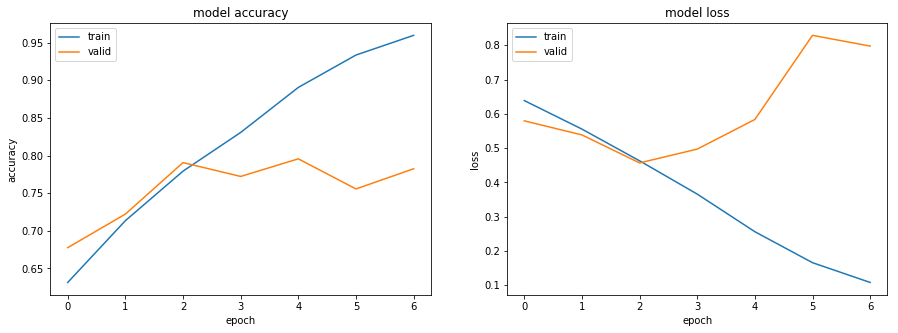

In [32]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

## Plot a few examples

## Evaluate the model